## 1) Import libraries

In [1]:
import sys
sys.path.append("./Tagging/lib/python3.6/site-packages")

import numpy as np
import pandas as pd

import re

import matplotlib.pyplot as plt

from functions import *

import pickle

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

from scipy import sparse

import math

In [2]:
def splitAtUpperCase(s):
    for i in range(len(s)-1)[::-1]:
        if s[i].isupper() and s[i+1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isupper() and s[i-1].islower():
            s = s[:i]+' '+s[i:]
        if s[i].isdigit() and s[i+1].isalpha():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isdigit() and s[i-1].isalpha():
            s = s[:i]+' '+s[i:]
        if s[i].isalpha() and s[i+1].isdigit():
            s = s[:i+1]+' '+s[i+1:]
        if s[i].isalpha() and s[i-1].isdigit():
            s = s[:i]+' '+s[i:]
    return s.split()

## 2) Import data

In [3]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)

In [4]:
len(data["connRef"].unique())

37

In [5]:
data = pd.read_csv("dataset_whole.csv", index_col = 0)
data = data.drop(["inverted"],axis=1)
data_serviceType = pd.read_csv("dataset_whole_1.csv", index_col = 0)[["serviceType"]]

In [6]:
building_test = data["connRef"].unique()[0]

In [7]:
building_test

'LBG 50014000 Brindley Place'

In [8]:
test = data[data["connRef"]==building_test]
train = data[data["connRef"]!=building_test]

In [9]:
X_train = train[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
X_test = test[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]

y_train = train.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)
y_test = test.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [10]:
data.head()

navName                      connRef contractRef  \
0  5thFlr DX3 Cash Office Enable  LBG 50014000 Brindley Place         LBG   
1   DX Unit 3 5th Post Room Temp  LBG 50014000 Brindley Place         LBG   
2      6thFlr DX1 Kitchen Enable  LBG 50014000 Brindley Place         LBG   
3    DX Unit 1 Kitchen Room Temp  LBG 50014000 Brindley Place         LBG   
4      6thFlr DX2 Meeting Enable  LBG 50014000 Brindley Place         LBG   

  controllerReference pointReference    kind unit  hisInterval  hisSize  air  \
0               L1O11        D11(Sv)    Bool    0        300.0  58820.0    0   
1               L1O11         S10(V)  Number   °C        300.0  58822.0    1   
2               L1O11         D9(Sv)    Bool    0        300.0  58823.0    0   
3               L1O11          S8(V)  Number   °C        300.0  58816.0    1   
4               L1O11        D10(Sv)    Bool    0        300.0  58820.0    0   

   ...   recirc  return  run  sensor  sp  speed  temp  valve  water  zone  
0  ...        0       0    0       0   0      0     0      0      0     0  
1  ...        0       0    0       1   0      0     1      0      0     0  
2  ...        0       0    0       0   0      0     0      0      0     0  
3  ...        0       0    0       1   0      0     1      0      0     0  
4  ...        0       0    0       0   0      0     0      0      0     0  

[5 rows x 47 columns]

## 3) Parsing Data

### Uncomment when not selecting a specific building

In [11]:
#from sklearn.model_selection import train_test_split

In [12]:
#X = data[["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"]]
#y = data.drop(["navName", "connRef", "contractRef", "controllerReference", "pointReference","kind", "unit", "hisInterval", "hisSize"], axis = 1)

In [13]:
#X_train, X_test, y_train, y_test, serviceType_train, serviceType_test = train_test_split(X.reset_index(drop=True), y.reset_index(drop=True), data_serviceType, test_size=0.1, random_state=42)

--------------------------------------------------------------------------------------------------

In [14]:
y_train_1 = y_train[["cmd", "sp", "sensor"]]
y_test_1 = y_test[["cmd", "sp", "sensor"]]

header = y_train.columns.tolist()
header.remove("cmd")
header.remove("sp")
header.remove("sensor")
y_train_2 = y_train[header]
y_test_2 = y_test[header]

### 3.1) Labels (navName)

In [15]:
labels_list_train = X_train[["navName"]].values.tolist()
labels_list_test = X_test[["navName"]].values.tolist()

In [16]:
# importing modules 
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
   
ps = PorterStemmer() 

In [17]:
dictionary = pd.read_csv("dict.csv",header=None).set_index(0).T.to_dict("list")

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  """Entry point for launching an IPython kernel.


In [18]:
def labels_processing(labels_list, dictionary):
    labels = []
    for label in labels_list:
        
        #label = splitAtUpperCase(label[0])

        #label = label[0].lower()
        #print(label)
        #label = re.sub(r"[0-9]","",label)
        label = re.sub("[.]"," ",label[0])
        #label = label.lower().split()
        label = splitAtUpperCase(label)
        for i in range(0,len(label)):
            label[i] = label[i].lower()
            if label[i] in dictionary:
                label[i] = dictionary[label[i]][0]
        #label = " ".join(label)
        labels += [label] 
        
    return labels

In [19]:
labels_train = labels_processing(labels_list_train, dictionary)
labels_test = labels_processing(labels_list_test, dictionary)

In [20]:
labels = []
for w in labels_train:
    labels += [[ps.stem(word) for word in w]]
labels_train = labels
labels = []
for w in labels_test:
    labels += [[ps.stem(word) for word in w]]
labels_test = labels

In [21]:
labels_train = [" ".join(i) for i in labels_train]
labels_test = [" ".join(i) for i in labels_test]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
count_vect = CountVectorizer(ngram_range=(1,2))
count_vect.fit(labels_train)
count_vect.fit(labels_test)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
labels_sparse_train = count_vect.transform(labels_train)
labels_sparse_test = count_vect.transform(labels_test)

In [24]:
# Helper function
#def print_topics(model, count_vectorizer, n_top_words):
 #   words = count_vectorizer.get_feature_names()
  #  for topic_idx, topic in enumerate(model.components_):
   #     print("\nTopic #%d:" % topic_idx)
    #    print(" ".join([words[i]
     #                   for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [25]:
# Load the LDA model from sk-learn
#from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tweak the two parameters below
#number_topics = 20
#number_words = 10
# Create and fit the LDA model
#lda = LDA(n_components=number_topics)
#lda.fit(labels_sparse_train)

In [26]:
#labels_sparse_train.shape

In [27]:
#lda_categories_train = lda.transform(labels_sparse_train)
#lda_categories_test = lda.transform(labels_sparse_test)

In [28]:
#print_topics(lda, count_vect, number_words)

In [29]:
#lda_sparse_train = sparse.csr_matrix(lda_categories_train)
#lda_sparse_test = sparse.csr_matrix(lda_categories_test)

### 3.2) Lan/outstation

In [30]:
lanOut = [re.sub("\D"," ",field[0]).split() for field in data[["controllerReference"]].values.tolist()]

lanOut_train = [re.sub("\D"," ",field[0]).split() for field in X_train[["controllerReference"]].values.tolist()]
lanOut_test = [re.sub("\D"," ",field[0]).split() for field in X_test[["controllerReference"]].values.tolist()]

In [31]:
#transform in "int" type the first vector member
for i in range(0, len(lanOut)):
    lanOut[i][0]=int(lanOut[i][0])
for i in range(0, len(lanOut_train)):
    lanOut_train[i][0]=int(lanOut_train[i][0])
for i in range(0, len(lanOut_test)):
    lanOut_test[i][0]=int(lanOut_test[i][0])

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc.fit(lanOut)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [33]:
lanOut_train = enc.transform(lanOut_train)
lanOut_test = enc.transform(lanOut_test)

In [34]:
lanOut_sparse_train = sparse.csr_matrix(lanOut_train)
lanOut_sparse_test = sparse.csr_matrix(lanOut_test)

In [35]:
lanOut_sparse_train.shape, lanOut_sparse_test.shape

((40472, 155), (1820, 155))

### 3.3) Controller Ref

In [36]:
controllerRef = data[["pointReference"]].values.tolist()

controllerRef_train = X_train[["pointReference"]].values.tolist()
controllerRef_test = X_test[["pointReference"]].values.tolist()

In [37]:
#Substitute parenthesis by blank space
conRef_process1 = [re.sub("[()]"," ",controllerRef[i][0]) for i in range(0,len(controllerRef))]

conRef_process1_train = [re.sub("[()]"," ",controllerRef_train[i][0]) for i in range(0,len(controllerRef_train))]
conRef_process1_test = [re.sub("[()]"," ",controllerRef_test[i][0]) for i in range(0,len(controllerRef_test))]

In [38]:
third_field = [conRef_process1[i].split()[1] for i in range(0,len(conRef_process1))]

third_field_train = [conRef_process1_train[i].split()[1] for i in range(0,len(conRef_process1_train))]
third_field_test = [conRef_process1_test[i].split()[1] for i in range(0,len(conRef_process1_test))]

In [39]:
first_field = [conRef_process1[i][0] for i in range(0,len(conRef_process1))]

first_field_train = [conRef_process1_train[i][0] for i in range(0,len(conRef_process1_train))]
first_field_test = [conRef_process1_test[i][0] for i in range(0,len(conRef_process1_test))]

In [40]:
second_field = [conRef_process1[i].split()[0][1:] for i in range(0,len(conRef_process1))]

second_field_train = [conRef_process1_train[i].split()[0][1:] for i in range(0,len(conRef_process1_train))]
second_field_test = [conRef_process1_test[i].split()[0][1:] for i in range(0,len(conRef_process1_test))]

In [41]:
conRef = [[first_field[i],second_field[i],third_field[i]] for i in range(0, len(first_field))]

conRef_train = [[first_field_train[i],second_field_train[i],third_field_train[i]] for i in range(0, len(first_field_train))]
conRef_test = [[first_field_test[i],second_field_test[i],third_field_test[i]] for i in range(0, len(first_field_test))]

In [42]:
enc_ref = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_ref.fit(conRef)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [43]:
conRef_train = enc_ref.transform(conRef_train)
conRef_test = enc_ref.transform(conRef_test)

In [44]:
conRef_sparse_train = sparse.csr_matrix(conRef_train)
conRef_sparse_test = sparse.csr_matrix(conRef_test)

In [45]:
conRef_sparse_train.shape, conRef_sparse_test.shape

((40472, 237), (1820, 237))

### 3.4) Kind

In [46]:
kind = data[["kind"]].values.tolist()

kind_train = X_train[["kind"]].values.tolist()
kind_test = X_test[["kind"]].values.tolist()

enc_kind = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_kind.fit(kind)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [47]:
kind_train = enc_kind.transform(kind_train)
kind_test = enc_kind.transform(kind_test)

In [48]:
kind_sparse_train = sparse.csr_matrix(kind_train)
kind_sparse_test = sparse.csr_matrix(kind_test)

### 3.5) Units

In [49]:
units = data[["unit"]].values.tolist()

units_train = X_train[["kind"]].values.tolist()
units_test = X_test[["kind"]].values.tolist()

enc_units = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_units.fit(units)

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='ignore',
       n_values=None, sparse=True)

In [50]:
units_train = enc_units.transform(units_train)
units_test = enc_units.transform(units_test)

In [51]:
units_sparse_train = sparse.csr_matrix(units_train)
units_sparse_test = sparse.csr_matrix(units_test)

## 4) Concatenate all

In [52]:
sX_train = sparse.hstack([labels_sparse_train,conRef_sparse_train,lanOut_sparse_train,kind_sparse_train,units_sparse_train])
sX_test = sparse.hstack([labels_sparse_test,conRef_sparse_test,lanOut_sparse_test,kind_sparse_test,units_sparse_test])

In [53]:
sX_train.shape, sX_test.shape

((40472, 1108), (1820, 1108))

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [55]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train,y_train_1.values)

# predict
predictions = classifier_1.predict(sX_test)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Accuracy = ",accuracy_score(y_test_1,predictions))
print("\n")

Accuracy =  0.9873626373626374


CPU times: user 10.6 s, sys: 20.3 ms, total: 10.6 s
Wall time: 10.7 s


In [56]:
probabilities_1 = classifier_1.predict_proba(sX_test)

In [61]:
probabilities_1[2][1]

array([0.01, 0.99])

In [55]:
threshold = 0.80

In [56]:
TF_matrix = [[max(probabilities_1[0][i]) < threshold, max(probabilities_1[1][i]) < threshold, max(probabilities_1[2][i]) < threshold] for i in range(0, len(probabilities_1[0]))]
revise_1 = [True in row for row in TF_matrix]

In [57]:
pred_1 = pd.DataFrame(predictions.tolist(), columns = ["cmd", "sp", "sensor"])

In [58]:
predictions.shape, sX_test.shape, y_train_2.shape

((1820, 3), (1820, 1108), (40472, 35))

In [59]:
spredictions = sparse.csr_matrix(predictions) 

In [60]:
sX_train.shape, spredictions.shape

((40472, 1108), (1820, 3))

In [61]:
#Preparing new test data (test_1 + predictions)
spredictions = sparse.csr_matrix(predictions) 
sX_test_2 = sparse.hstack([sX_test,spredictions])

#Preparing new training data (train_1 + y_train_1)
sX_train_2 = sparse.hstack([sX_train,y_train_1])

In [62]:
%%time

# initialize label powerset multi-label classifier
classifier_2 = LabelPowerset(RandomForestClassifier(n_estimators=100))

# train
classifier_2.fit(sX_train_2, y_train_2)

# predict
predictions_2 = classifier_2.predict(sX_test_2)
predictions_train_2 = classifier_2.predict(sX_train_2)
#predictions_val = classifier.predict(data_val)

# accuracy
print("Training Accuracy = ",accuracy_score(y_train_2,predictions_train_2))
print("Test Accuracy = ",accuracy_score(y_test_2,predictions_2))
print("\n")

Training Accuracy =  0.9713629175726428
Test Accuracy =  0.8620879120879121


CPU times: user 1min, sys: 3.35 s, total: 1min 3s
Wall time: 1min 3s


In [63]:
results_table = predictions_2.toarray()
probabilities_2 = classifier_2.predict_proba(sX_test_2)

In [64]:
inf_threshold = 0.15
condition = probabilities_2.toarray()[3] > inf_threshold

In [65]:
revise_2 = [np.extract(probabilities_2.toarray()[i] > inf_threshold, probabilities_2.toarray()[i]).mean() < threshold for i in range(0,len(probabilities_2.toarray()))]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
./Tagging/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [66]:
revise_2[106]

False

In [67]:
probabilities_2.toarray()[106]

array([0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  ,
       0.01, 0.01])

In [68]:
prediction_confidence = [np.extract(probabilities_2.toarray()[i] > inf_threshold, probabilities_2.toarray()[i]).mean() for i in range(0,len(probabilities_2.toarray()))]
revise_2 = [np.extract(np.extract(probabilities_2.toarray()[i] > inf_threshold, probabilities_2.toarray()[i])<threshold,np.extract(probabilities_2.toarray()[i] > inf_threshold, probabilities_2.toarray()[i])).mean()<threshold for i in range(0,len(probabilities_2.toarray()))]

#prediction_confidence = [1 if math.isnan(x) else x for x in prediction_confidence]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
./Tagging/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  


In [69]:
prediction_confidence = [1 if math.isnan(x) else x for x in prediction_confidence]

In [70]:
prediction_confidence[106]

1

In [71]:
np.extract(np.extract(probabilities_2.toarray()[106] > inf_threshold, probabilities_2.toarray()[106])<0.8,np.extract(probabilities_2.toarray()[106] > inf_threshold, probabilities_2.toarray()[106])).mean()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
./Tagging/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [72]:
revision_needed = [element_1 == False and element_2 == False for element_1,element_2 in zip(revise_1, revise_2)]

In [73]:
revision_needed[106]

True

In [74]:
# % of elements that can pass without revision
(len(revision_needed)-revision_needed.count(False))/len(revision_needed)*100

74.94505494505495

In [75]:
100-74.01

25.989999999999995

In [76]:
len(results_table)

1820

In [77]:
1867*0.2591

483.73969999999997

In [78]:
pred_2 = pd.DataFrame(results_table.tolist(), columns = header)

In [79]:
pred = pd.concat([pred_1,pred_2],axis=1).astype(int)

In [80]:
test = y_test.copy()
#test = pd.concat([pd.DataFrame(test_1, columns = header_1).reset_index(drop=True), pd.DataFrame(test_2, columns = header_2).reset_index(drop=True)], axis=1)

In [81]:
#The actual and predicted dataframes have headers sorted differently, so we equal them
test = test[list(pred)]

In [82]:
acc_list = [test.iloc[i].values.tolist() == pred.iloc[i].values.tolist() for i in range(0,len(test))]

In [83]:
test_tags = [list(filter(None, test.iloc[i].values * test.columns.values)) for i in range(0,len(test))]
pred_tags = [list(filter(None, pred.iloc[i].values * pred.columns.values)) for i in range(0,len(pred))]

In [84]:
dict_results = {"Label Name":X_test["navName"].values.tolist(),"Actual Tags":test_tags,"Predicted Tags":pred_tags, "Success":acc_list, "Prediction confidence":prediction_confidence, "No Revision Needed":revision_needed}

In [85]:
accuracy_total = (len(acc_list)-acc_list.count(False))/len(acc_list)*100

In [86]:
accuracy_total

86.20879120879121

In [87]:
results = pd.DataFrame(dict_results)
results

Label Name  \
0      5thFlr DX3 Cash Office Enable   
1       DX Unit 3 5th Post Room Temp   
2          6thFlr DX1 Kitchen Enable   
3        DX Unit 1 Kitchen Room Temp   
4          6thFlr DX2 Meeting Enable   
5     DX Unit 2 6th Meeting Room Tmp   
6                   Chiller 1 Enable   
7                 Chiller No.1 Fault   
8                   Chiller No.1 Run   
9                   Chiller 2 Enable   
10                Chiller No.2 Fault   
11                  Chiller No.2 Run   
12                  Chiller Core Hrs   
13                 Chiller Flow Temp   
14               Chiller Return Temp   
15           ChW Calculated Setpoint   
16                 CHW Pump 1 Enable   
17               CHW Pump1 inv Fault   
18             CHW Pump1 Inverter OP   
19                   CWSPriPump1Fail   
20              CWSPump1 Speed Setpt   
21                 CHW Pump 2 Enable   
22                    CHW Pump2 Flow   
23               CHW Pump2 inv Fault   
24             CHW Pump2 Inverter OP   
25                   CWSPriPump2Fail   
26              CWSPump2 Speed Setpt   
27       Chilllers Eco Mode Setpoint   
28                    CHW Pump1 Flow   
29                   CHW PUnit Fault   
...                              ...   
1790              WestAHU RAC Enable   
1791                WestAHU RAC Trip   
1792               WestAHU RAC Valve   
1793             WestAHU SFan Failed   
1794            WestAHUSFan Inverter   
1795              WestAHU SFan 0-10V   
1796             WestAHU SFan Enable   
1797                WestAHU SFan Run   
1798          West  AHU Supply Setpt   
1799          West  AHU Supply Setpt   
1800                    West AHU CO2   
1801               West AHU Core Hrs   
1802           West AHU Sup Humidity   
1803            West AHU Supply Temp   
1804           WestAHU Cooling Valve   
1805             WestAHU DeHum Setpt   
1806             WestAHU EFan Damper   
1807            WestAHU Extract Temp   
1808    WestAHU Frost Stat Condition   
1809         WestAHU Frost Stat Trip   
1810             WestAHU Frost Valve   
1811           WestAHU Heating Valve   
1812               WestAHU Hum Fault   
1813       WestAHU Humidifier Enable   
1814           WestAHU Humidifier OP   
1815          WestAHU Humidity Setpt   
1816             WestAHU SFan Damper   
1817            WestAHU SupTmp Alarm   
1818              WestAHUEFan Damper   
1819              WestAHUSFan Damper   

                                   Actual Tags  \
0                                        [cmd]   
1                          [sensor, air, temp]   
2                                        [cmd]   
3                          [sensor, air, temp]   
4                                        [cmd]   
5                          [sensor, air, temp]   
6                                   [cmd, run]   
7                              [sensor, alarm]   
8                                [sensor, run]   
9                                   [cmd, run]   
10                             [sensor, alarm]   
11                               [sensor, run]   
12                              [sp, occupied]   
13     [sensor, chilled, leaving, temp, water]   
14    [sensor, chilled, entering, temp, water]   
15                 [sp, entering, temp, water]   
16                                  [cmd, run]   
17                             [sensor, alarm]   
18                                [cmd, speed]   
19                             [sensor, alarm]   
20                                        [sp]   
21                                  [cmd, run]   
22                               [sensor, run]   
23                             [sensor, alarm]   
24                                [cmd, speed]   
25                             [sensor, alarm]   
26                                        [sp]   
27                                        [sp]   
28                                    [sensor]   
29                             [sensor, alarm

In [88]:
len(results)

1820

In [89]:
no_success = results[results["Success"]==False]

In [90]:
54/1820

0.02967032967032967

In [91]:
len(no_success)

251

In [92]:
len(no_success[no_success["No Revision Needed"]==True])

58

In [93]:
false_possitives = no_success[no_success["No Revision Needed"]==True]

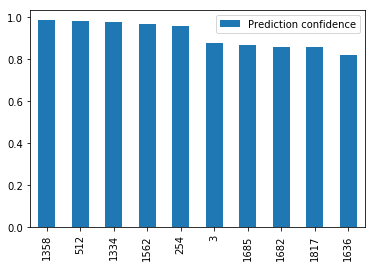

In [101]:
#df = pd.DataFrame({'lab':['A', 'B', 'C'], 'val':[10, 30, 20]})
ax = false_possitives[["Label Name","Prediction confidence"]].sort_values(by=["Prediction confidence"], ascending=False).iloc[-10:].plot.bar(rot=90)

In [95]:
false_possitives

Label Name                     Actual Tags  \
3        DX Unit 1 Kitchen Room Temp             [sensor, air, temp]   
53                 Generator On Load                 [sensor, alarm]   
254                  Plant Room Temp             [sensor, air, temp]   
332                       Space temp       [sensor, air, temp, zone]   
338                       Space temp       [sensor, air, temp, zone]   
494                       Space temp       [sensor, air, temp, zone]   
500                       Space temp       [sensor, air, temp, zone]   
506                       Space temp       [sensor, air, temp, zone]   
512                       Space temp       [sensor, air, temp, zone]   
1190                      Space temp       [sensor, air, temp, zone]   
1196                      Space temp       [sensor, air, temp, zone]   
1202                      Space temp       [sensor, air, temp, zone]   
1214                      Space temp       [sensor, air, temp, zone]   
1226                      Space temp       [sensor, air, temp, zone]   
1232                      Space temp       [sensor, air, temp, zone]   
1238                      Space temp       [sensor, air, temp, zone]   
1256                      Space temp       [sensor, air, temp, zone]   
1262                      Space temp       [sensor, air, temp, zone]   
1268                      Space temp       [sensor, air, temp, zone]   
1274                      Space temp       [sensor, air, temp, zone]   
1280                      Space temp       [sensor, air, temp, zone]   
1286                      Space temp       [sensor, air, temp, zone]   
1304                      Space temp       [sensor, air, temp, zone]   
1310                      Space temp       [sensor, air, temp, zone]   
1316                      Space temp       [sensor, air, temp, zone]   
1322                      Space temp       [sensor, air, temp, zone]   
1328                      Space temp       [sensor, air, temp, zone]   
1334                      Space temp       [sensor, air, temp, zone]   
1340                      Space temp       [sensor, air, temp, zone]   
1346                      Space temp       [sensor, air, temp, zone]   
1352                      Space temp       [sensor, air, temp, zone]   
1358                      Space temp       [sensor, air, temp, zone]   
1539                      Space temp       [sensor, air, temp, zone]   
1562                 UPS Room Temp 1       [sensor, air, temp, zone]   
1604  Atrium3rd Stage Frost Setpoint                 [sp, air, temp]   
1631                EastAHU EFan Run                   [sensor, run]   
1636              East  AHU Deadband                            [sp]   
1648             EastAHU SFan Enable                      [cmd, run]   
1649                EastAHU SFan Run                   [sensor, run]   
1654                KitAHU EFan Flow                   [sensor, run]   
1677                KitAHU SFan Flow                   [sensor, run]   
1682         LB AHU Supply Flow Fail  [sensor, air, discharge, flow]   
1685        LB AHU Supply Temp Alarm  [sensor, air, discharge, flow]   
1690    Low Bsmnt Smoke Ext Fan Flow                   [sensor, run]   
1700         LB AHU Frost Coil Setpt                 [sp, air, temp]   
1711          LoadingBay SE Fan Flow                   [sensor, run]   
1718           CarParkLBas EFan Flow                   [sensor, run]   
1719            Low Base CP Ext LL01                      [cmd, run]   
1727           Main Lift EFan Enable                      [cmd, run]   
1731            Sat Lift EFan Enable                      [cmd, run]   
1736             Sub Station Ext Fan                      [cmd, run]   
1764        Up Base CP Ext EF04 High                      [cmd, run]   
1765         Up Base CP Ext EF04 Low                      [cmd, run]   
1781             WestAHU EFan Enable                      [cmd, run]   
1782                WestAHU EFan Run                   [sensor, ru

In [96]:
X_train.shape

(40472, 9)

# Service type

In [97]:
serviceType = [[word] for word in data_serviceType["serviceType"].str.lower().values.tolist()]

In [98]:
#serviceType = data_serviceType["serviceType"].str.lower().values.tolist()

serviceType_train = serviceType_train.values.tolist()
serviceType_test = serviceType_test.values.tolist()

enc_servType = OneHotEncoder(handle_unknown='ignore')
#X = [['Male', 1], ['Female', 3], ['Female', 2]]
enc_servType.fit(serviceType)

NameError: name 'serviceType_train' is not defined

In [ ]:
enc_servType.categories_

In [ ]:
serviceType_train = enc_servType.transform(serviceType_train)
serviceType_test = enc_servType.transform(serviceType_test)

serviceType_train = serviceType_train.astype('int')
serviceType_test = serviceType_test.astype('int')

In [ ]:
serviceType_train.shape

In [ ]:
serviceType_sparse_train = sparse.csr_matrix(serviceType_train)
serviceType_sparse_test = sparse.csr_matrix(serviceType_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [ ]:
#Preparing new test data (test_1 + predictions)
spredictions = sparse.csr_matrix(predictions_2) 
sX_test_3 = sparse.hstack([sX_test_2,spredictions])

#Preparing new training data (train_1 + y_train_1)
sX_train_3 = sparse.hstack([sX_train_2,y_train_2])

In [ ]:
%%time

# initialize label powerset multi-label classifier
classifier_1 = RandomForestClassifier(n_estimators=100)

# train
classifier_1.fit(sX_train_3, serviceType_sparse_train.toarray())

# predict
predictions = classifier_1.predict(sX_test_3)
#predictions_val = classifier_1.predict(data_val)

# accuracy
print("Accuracy = ",accuracy_score(serviceType_test,predictions))
print("\n")